C:\Users\tezas\AppData\Local\Temp\ipykernel_23720\1013003562.py:94: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(grid_on, color=style["GRID_COLOR"], alpha=0.35)


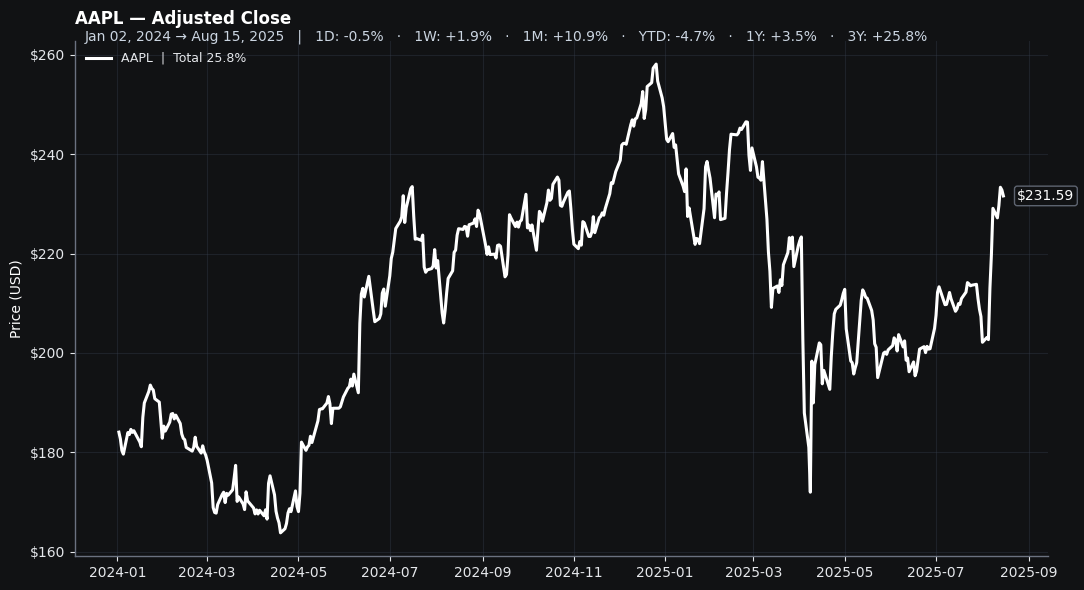

In [18]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from typing import Optional, Iterable, Dict

# =========================
# ======= THEMES ==========
# =========================
LIGHT_MODE = {
    "FIGURE_BACKGROUND":  "#ffffff",
    "PLOT_BACKGROUND":    "#ffffff",
    "AXIS_LINE_COLOR":    "#9ca3af",
    "TICK_COLOR":         "#374151",
    "AXIS_LABEL_COLOR":   "#111827",
    "TITLE_COLOR":        "#111827",
    "SUBTITLE_COLOR":     "#4b5563",
    "LEGEND_TEXT_COLOR":  "#374151",
    "GRID_COLOR":         "#e5e7eb",
    "MAIN_LINE_COLOR":    "#2563eb",
    "MA_COLOR":           "#6b7280",
}

DARK_MODE = {
    "FIGURE_BACKGROUND":  "#111214",
    "PLOT_BACKGROUND":    "#111214",
    "AXIS_LINE_COLOR":    "#6b7280",
    "TICK_COLOR":         "#e5e7eb",
    "AXIS_LABEL_COLOR":   "#ffffff",
    "TITLE_COLOR":        "#ffffff",
    "SUBTITLE_COLOR":     "#cbd5e1",
    "LEGEND_TEXT_COLOR":  "#e5e7eb",
    "GRID_COLOR":         "#384151",
    "MAIN_LINE_COLOR":    "#ffffff",
    "MA_COLOR":           "#9ca3af",
}

# Pick mode here: "light" or "dark"
MODE = "dark"
STYLE = DARK_MODE if MODE == "dark" else LIGHT_MODE

#Change Tickers here
OPTIONS = {
    "TICKER": "AAPL",
    "START":  "2024-01-01",
    "END":    None,

    "SHOW_MA": False,
    "MA_WINDOWS": (50, 200),
    "GRID_ON": False,

    # NEW:
    "HIDE_TOP_RIGHT": True,   # ← hide top & right spines if True

    "PRICE_LINEWIDTH": 2.2,
    "MA_LINEWIDTH": 1.4,

    "SAVE_PATH": None, #'name.png' ← to download
}


def _currency_fmt(ax):
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y:,.0f}"))

def _apply_style(fig, ax, grid_on: bool, style: dict, hide_top_right: bool):
    # backgrounds
    fig.patch.set_facecolor(style["FIGURE_BACKGROUND"])
    ax.set_facecolor(style["PLOT_BACKGROUND"])

    # spines
    # always style left/bottom (primary axes)
    for side in ("left", "bottom"):
        ax.spines[side].set_color(style["AXIS_LINE_COLOR"])
        ax.spines[side].set_linewidth(1.0)

    if hide_top_right:
        # hide top & right for a minimalist look
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        # style all four sides
        for side in ("top", "right"):
            ax.spines[side].set_color(style["AXIS_LINE_COLOR"])
            ax.spines[side].set_linewidth(1.0)
            ax.spines[side].set_visible(True)

    # ticks & labels
    ax.tick_params(axis="x", colors=style["TICK_COLOR"])
    ax.tick_params(axis="y", colors=style["TICK_COLOR"])
    ax.xaxis.label.set_color(style["AXIS_LABEL_COLOR"])
    ax.yaxis.label.set_color(style["AXIS_LABEL_COLOR"])

    # grid
    ax.grid(grid_on, color=style["GRID_COLOR"], alpha=0.35)

def fetch_close_series(ticker: str, start: str, end: Optional[str]) -> pd.Series:
    df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    if df.empty:
        raise ValueError(f"No data for {ticker}.")
    s = df["Close"]
    if isinstance(s, pd.DataFrame):
        s = s.squeeze("columns")
    return s.dropna()

def _first_index_on_or_after(idx: pd.DatetimeIndex, date: pd.Timestamp) -> Optional[pd.Timestamp]:
    pos = idx.searchsorted(date)
    return idx[pos] if pos < len(idx) else None

def compute_period_returns(close: pd.Series) -> Dict[str, float]:
    last = float(close.iloc[-1])
    idx = close.index
    refs = {
        "1D": idx[-2] if len(idx) >= 2 else None,
        "1W": idx[-5] if len(idx) >= 5 else None,
        "1M": _first_index_on_or_after(idx, idx[-1] - pd.DateOffset(months=1)),
        "YTD": _first_index_on_or_after(idx, pd.Timestamp(year=idx[-1].year, month=1, day=1)),
        "1Y": _first_index_on_or_after(idx, idx[-1] - pd.DateOffset(years=1)),
        "3Y": _first_index_on_or_after(idx, idx[-1] - pd.DateOffset(years=3)),
        "5Y": _first_index_on_or_after(idx, idx[-1] - pd.DateOffset(years=5)),
    }
    out = {}
    for k, ts in refs.items():
        if ts is None: continue
        base = float(close.loc[ts])
        out[k] = (last / base - 1.0) * 100.0
    out["Total"] = (last / float(close.iloc[0]) - 1.0) * 100.0
    return out

def plot_ticker(
    ticker: str,
    start: str,
    end: Optional[str] = None,
    show_ma: bool = True,
    ma_windows: Iterable[int] = (50, 200),
    price_lw: float = 2.2,
    ma_lw: float = 1.4,
    grid_on: bool = True,
    save_path: Optional[str] = None,
    mode: str = "dark",
    style: Optional[dict] = None,
    hide_top_right: bool = True,   # ← NEW
):
    style = style or (DARK_MODE if mode.lower() == "dark" else LIGHT_MODE)

    close = fetch_close_series(ticker, start, end)
    first_dt = close.index[0].strftime("%b %d, %Y")
    last_dt  = close.index[-1].strftime("%b %d, %Y")
    last_price = float(close.iloc[-1])
    rets = compute_period_returns(close)

    fig, ax = plt.subplots(figsize=(11, 6))
    _apply_style(fig, ax, grid_on, style, hide_top_right)   # ← pass it here
    _currency_fmt(ax)

    # price line
    ax.plot(close.index, close.values,
            color=STYLE["MAIN_LINE_COLOR"], linewidth=price_lw,
            label=f"{ticker.upper()}  |  Total {rets.get('Total', float('nan')):.1f}%")

    # MAs
    if show_ma:
        for w in ma_windows:
            if w < len(close):
                ax.plot(close.index, close.rolling(w).mean().values,
                        color=STYLE["MA_COLOR"], linewidth=ma_lw,
                        alpha=0.9, label=f"MA{w}")

    # labels
    ax.set_title(f"{ticker.upper()} — Adjusted Close",
                 loc="left", pad=12, fontweight="bold", color=STYLE["TITLE_COLOR"])
    ax.set_xlabel("")
    ax.set_ylabel("Price (USD)")

    # last price annotation
    ax.annotate(f"${last_price:,.2f}",
                xy=(close.index[-1], last_price),
                xytext=(10, 0),
                textcoords="offset points",
                va="center", fontsize=10, color=STYLE["AXIS_LABEL_COLOR"],
                bbox=dict(boxstyle="round,pad=0.2", fc=STYLE["PLOT_BACKGROUND"],
                          ec=STYLE["AXIS_LINE_COLOR"], alpha=0.85))

    # subtitle with returns
    buckets = ["1D", "1W", "1M", "YTD", "1Y", "3Y"]
    ret_bits = "   ·   ".join(f"{k}: {rets[k]:+.1f}%" for k in buckets if k in rets)
    subtitle = f"{first_dt} → {last_dt}   |   {ret_bits}"
    ax.text(0.01, 1, subtitle, transform=ax.transAxes, fontsize=10, color=STYLE["SUBTITLE_COLOR"])

    # legend
    leg = ax.legend(loc="upper left", frameon=False, fontsize=9)
    for txt in leg.get_texts():
        txt.set_color(STYLE["LEGEND_TEXT_COLOR"])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=220, bbox_inches="tight", facecolor=STYLE["FIGURE_BACKGROUND"])
    plt.show()


#RUN
plot_ticker(
    ticker=OPTIONS["TICKER"],
    start=OPTIONS["START"],
    end=OPTIONS["END"],
    show_ma=OPTIONS["SHOW_MA"],
    ma_windows=OPTIONS["MA_WINDOWS"],
    price_lw=OPTIONS["PRICE_LINEWIDTH"],
    ma_lw=OPTIONS["MA_LINEWIDTH"],
    grid_on=OPTIONS["GRID_ON"],
    save_path=OPTIONS["SAVE_PATH"],
    mode="dark",  # or "light"
    hide_top_right=OPTIONS["HIDE_TOP_RIGHT"],  # ← toggle here
)

